Dataset Link:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Importing

In [1]:
import os  # module in Python provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.
import pandas as pd
import numpy as np 
import random
import tensorflow as tf 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
# Batch normalization is a standardization method that is applied before or after the activation functions of each layer to reduce the internal covariance shift effect
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

seed = 232 
np.random.seed(seed)  # is a method used to initialize the random number generator.
tf.random.set_seed(seed)

## Show some normal and pneumonia images to have a look at how much different  look. 

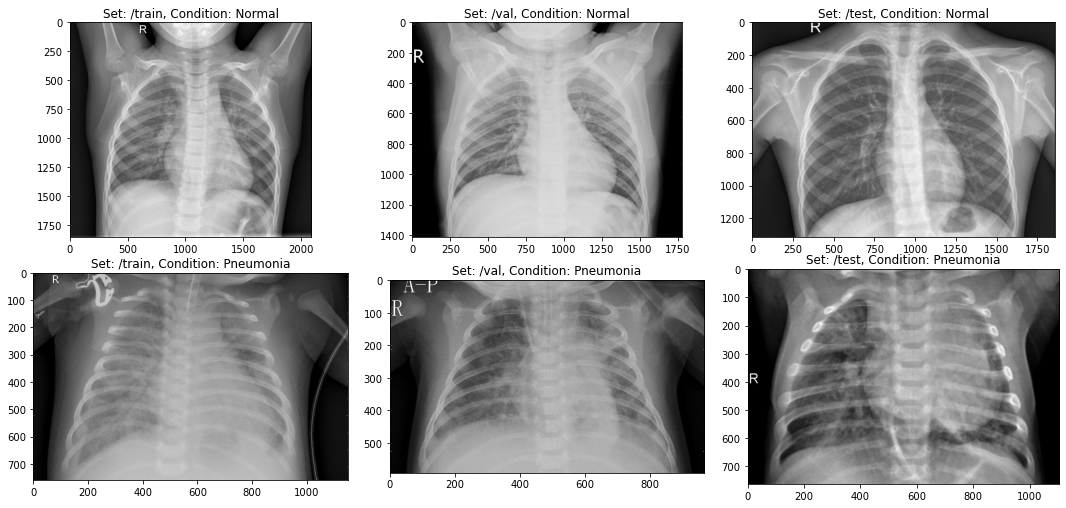

In [2]:
input_path = 'E:/bramji/archive/chest_xray'  # File Path

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['/train', '/val', '/test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

## Split the dataset into three sets train, validation and test. 

In [3]:
# Datasets Distribution
for _set in ['/train', '/val', '/test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: /train, normal images: 1341, pneumonia images: 3875
Set: /val, normal images: 8, pneumonia images: 8
Set: /test, normal images: 234, pneumonia images: 390


## Function for Data augmentation.

## Fed the training and test set images to the network and labels for the images.

## Defined a couple of data generators one for training data, and the other for validation data.

In [4]:
input_path = 'E:/bramji/archive/chest_xray'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory( 
    directory=input_path+'/train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'/test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # Predictions off of the test set in one batch size.
    # This useful to be able to get the confusion matrix.
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/test' + cond)):
            img = plt.imread(input_path+'/test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

## After defineing some later usage constants.

In [5]:
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Build the model:

In [6]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# Five convolutional blocks comprised of convolutional layer, max-pooling and batch-normalization 
# also in between I put dropouts to reduce over-fitting.
# 1st convolutional block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 2nd convolutional block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 3rd convolutional block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 4th convolutional block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# 5th convolutional block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Flatten layer and followed it by four fully connected layers also in between I put dropouts 
# to reduce over-fitting.
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

## Training the model for 10 epochs with a batch size of 32. 

In [7]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 [==============================] - 286s 2s/step - loss: 0.3834 - accuracy: 0.8184 - val_loss: 0.9173 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 273s 2s/step - loss: 0.2885 - accuracy: 0.8783 - val_loss: 0.7583 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.8961
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 274s 2s/step - loss: 0.2615 - accuracy: 0.8961 - val_loss: 0.6551 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 274s 2s/step - loss: 0.2153 - accuracy: 0.9218 - val_loss: 0.9553 - val_accuracy: 0.6299
Epoch 5/10
163/163 [==============================] - 273s 2s/step - loss: 0.1925 - accuracy: 0.9298 - val_loss: 0.8539 - val_accuracy: 0.6809
Epoch 6/10
163/163 [========================

- Train accuracy --> 95.02%
- Valdiation accuracy --> 90.3%

## Loss and accuracy visualization plots. 

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

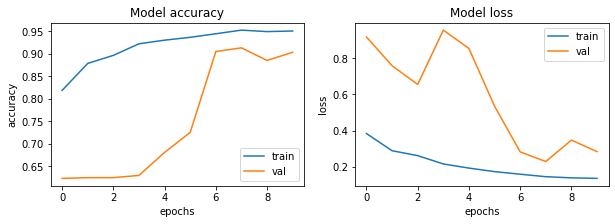

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- The model is converging which can be observed from the decrease in loss and validation loss with epochs.

 

## Confusion matrix plot and calculate precision, recall, F1 score and accuracy.

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX :-')
print(cm)

print('\nTEST METRICS :-')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC :-')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX :-
[[180  54]
 [  8 382]]

TEST METRICS :-
Accuracy: 90.06410256410257%
Precision: 87.61467889908256%
Recall: 97.94871794871794%
F1-score: 92.49394673123486

TRAIN METRIC :-
Train acc: 95.02


- From the Confusion Matrix the model has high True positive and high True negative.
- The accuracy is 90.06% that is very good considering the data size that is used.